In [1]:
import pennylane as qml
import pennylane.numpy as np
import numpy as illegal_but_typed_np
from numpy.typing import NDArray

## 1. Set up circuit to optimize

In [2]:
from circuits import sim_03

num_layers = 5
num_qubits = 4
circuit = sim_03(num_layers, num_qubits)
initial_params = (
    np.array(np.random.random((num_layers, num_qubits, 2))),
    np.array(np.random.random((num_layers, num_qubits - 1)))
)
print(qml.draw(circuit)(*initial_params))

# demo circuit from Rotosolve docs, crotosolve cannot solve this
# dev = qml.device('default.qubit', wires=3, shots=None)
# @qml.qnode(dev)
# def circuit(rot_param: NDArray, layer_param: float, crot_param: NDArray):
#     for i, par in enumerate(rot_param):
#         qml.RX(par, wires=i)
#     for w in dev.wires:
#         qml.RX(layer_param, wires=w)
#     for i, par in enumerate(crot_param):
#         qml.CRY(par, wires=[i, (i+1) % 3])
#     return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))
# params = (
#     np.array([0.3, 0.2, 0.67], requires_grad=True),
#     np.array(1.1, requires_grad=True),
#     np.array([-0.2, 0.1, -2.5], requires_grad=True)
# )

0: ──RX(0.90)──RZ(0.02)─────────────────────╭RZ(0.23)──||──RX(0.22)──RZ(0.57)────────────────────
1: ──RX(0.07)──RZ(0.92)───────────╭RZ(0.81)─╰●─────────||──RX(0.90)──RZ(0.39)───────────╭RZ(0.39)
2: ──RX(0.82)──RZ(0.41)─╭RZ(0.12)─╰●───────────────────||──RX(0.96)──RZ(0.40)─╭RZ(0.57)─╰●───────
3: ──RX(0.92)──RZ(0.75)─╰●─────────────────────────────||──RX(0.68)──RZ(0.71)─╰●─────────────────

──╭RZ(0.55)──||──RX(0.33)──RZ(0.81)─────────────────────╭RZ(0.40)──||──RX(0.18)──RZ(0.23)──────────
──╰●─────────||──RX(0.47)──RZ(0.35)───────────╭RZ(0.56)─╰●─────────||──RX(0.70)──RZ(0.73)──────────
─────────────||──RX(0.51)──RZ(0.46)─╭RZ(0.50)─╰●───────────────────||──RX(0.03)──RZ(0.35)─╭RZ(0.79)
─────────────||──RX(0.84)──RZ(0.66)─╰●─────────────────────────────||──RX(0.71)──RZ(0.31)─╰●───────

────────────╭RZ(0.79)──||──RX(0.14)──RZ(0.04)─────────────────────╭RZ(0.82)──||─┤     
──╭RZ(0.02)─╰●─────────||──RX(0.17)──RZ(0.43)───────────╭RZ(0.98)─╰●─────────||─┤  <Z>
──╰●───────────────────||──RX(0.

## 2. Run `Crotosolve` optimization

In [3]:
from CrotosolveOptimizer import CrotosolveOptimizer

# optimizer = qml.AdamOptimizer()

max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = CrotosolveOptimizer()

#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
params = initial_params
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker:
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1), # TODO: reduce once special treatment for RP gates is applied
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])
    print(cost)

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])
    print(cost)

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

crotosolve_cost = cost

[(0, 0.007885904077691741), (6, -0.22903321865654802), (12, -0.23237343284865342), (18, -0.28417481975278747), (24, -0.5920408155927855), (30, -0.8493346972616793), (36, -0.8500335932493308), (42, -0.851343369103033), (48, -0.8515058317129875), (54, -0.8515718933481549), (60, -0.8515723632883956), (66, -0.9930200567176654), (72, -0.9930913096949571), (78, -0.99424143455059), (84, -0.997508861005852), (90, -0.9975411964343041), (96, -0.997541244557611), (102, -0.9975726495854921), (108, -0.9976347349652042), (114, -0.9976634866652492), (120, -0.9976955162412569), (126, -0.9990670816865358), (132, -0.99906726951267), (138, -0.999067271897369), (144, -0.9990672718973687), (150, -0.999114757432433), (156, -0.9991147574324323), (162, -0.9991607703942867), (168, -0.9995464890034274), (174, -0.9995466243160069), (180, -0.9995466243160075), (186, -0.9995466243160073), (192, -0.999546624316007), (198, -0.9995466243160065), (204, -0.9995466243160076), (210, -0.9995674132853642), (216, -0.9995674

## 3. Run `Rotosolve` optimization

In [4]:
max_iterations = 5#100
convergence_threshold = 1e-06

optimizer = qml.RotosolveOptimizer()
params = initial_params

spectrum_fn = qml.fourier.qnode_spectrum(circuit)
spectra = spectrum_fn(*params)
#iterations_dataset = [circuit(params)] # store initial cost
cost = [(0, float(circuit(*initial_params)))]
for iteration in range(max_iterations):
    #with qml.Tracker(circuit.device) as tracker:
    params, prev_cost, sub_cost = optimizer.step_and_cost(
        circuit,
        *params,
        spectra=spectra,
        full_output=True
    )

    sub_cost_rp = sub_cost[:params[0].size]
    sub_cost_crp = sub_cost[params[0].size:]

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 2 * (cost_idx + 1) + 1,
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_rp)
    ])
    print(cost)

    evaluations_so_far = max([evs for (evs, _) in cost], default=0)
    cost.extend([
        (
            evaluations_so_far + 6 * (cost_idx + 1),
            float(cost_value)
        )
        for (cost_idx, cost_value)
        in enumerate(sub_cost_crp)
    ])
    print(cost)

    if np.abs(circuit(*params) - prev_cost) <= convergence_threshold:
        print("abort", iteration)
        break

rotosolve_cost = cost

[(0, 0.007885904077691741), (3, -0.22903321865655718), (5, -0.23237343506580108), (7, -0.2841748269039147), (9, -0.5920406667181484), (11, -0.849334583286054), (13, -0.8500334803582011), (15, -0.8513432550567641), (17, -0.8515057173974763), (19, -0.8515717777905227), (21, -0.8515722478044845), (23, -0.9930200699307992), (25, -0.9930913210250839), (27, -0.9942414374959313), (29, -0.9975088645206174), (31, -0.997541199999637), (33, -0.9975412481229352), (35, -0.9975726534063718), (37, -0.9976347387116405), (39, -0.9976634931326118), (41, -0.9976955231959025), (43, -0.9990670913804381), (45, -0.9990672792036414), (47, -0.99906728158829), (49, -0.9990672815882904), (51, -0.9991147681951243), (53, -0.9991147681951242), (55, -0.999160779546097), (57, -0.9995464966730944), (59, -0.9995466319917828), (61, -0.9995466319917828), (63, -0.9995466319917831), (65, -0.9995466319917824), (67, -0.9995466319917826), (69, -0.9995466319917826), (71, -0.9995674181723715), (73, -0.9995674181723719), (75, -0

## 4. Plot loss curve

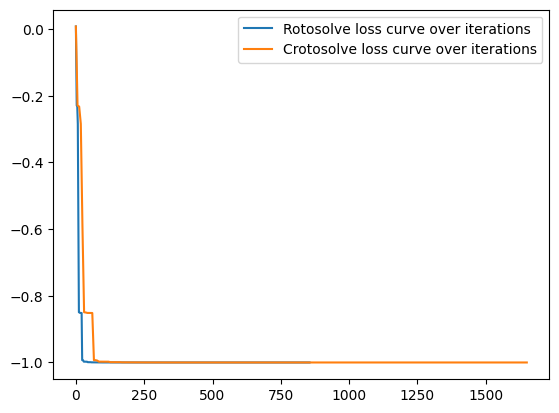

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
# ax.set_title("Loss curve over iterations")

for optimizer_name, loss_curve_data in [("Rotosolve", rotosolve_cost), ("Crotosolve", crotosolve_cost)]:
    x, y = zip(*loss_curve_data) # this unzips the list of points

    ax.plot(x, y, label=f"{optimizer_name} loss curve over iterations")
    ax.legend()